In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

In [2]:
def potential(r, axis=None):
    '''Compute a harmonic potential for a vector or time series.
    
    Arguments:
        r (array-like of float): a single n-dim vector or tn-dim time series
        axis (int): perform the summation along the given axis (for time series)
    '''
    return 0.5 * np.sum(r**2, axis=axis)

def nabla_potential(r):
    '''Compute a
    the gradient of a harmonic potential for a vector or time series.
    
    This function is rather cosmetic as the gradient is trivial.
    
    Arguments:
        r (array-like of float): a single n-dim vector or tn-dim time series
    '''
    return r

def vv(gradient, r_init, p_init, n_steps, dt=0.01, m=1.0):
    '''Perform a velocity verlet integration.
    
    This function propagates a ingle particle in a potential for which
    the gradient can be computed using the supplied reference. It returns
    the time series of positions and momenta.
    
    Arguments:
        gradient (function): reference to the gradient function
        r_init (array-like of float): the initial n-dim position vector
        p_init (array-like of float): the initial n-dim momentum vector
        n_steps (int): the number of timesteps
        dt (float): size of the timestep
        m (float): mass of the particle
    '''
    r, p = [np.asarray(r_init)], [np.asarray(p_init)]
    g = gradient(r[-1])
    for _ in range(n_steps):
        p.append(p[-1] - 0.5 * dt * g)
        r.append(r[-1] + dt * p[-1] / m)
        g = gradient(r[-1])
        p[-1] -= 0.5 * dt * g
    return np.asarray(r), np.asarray(p)

## Sandbox

Feel free to experiment with the settings.

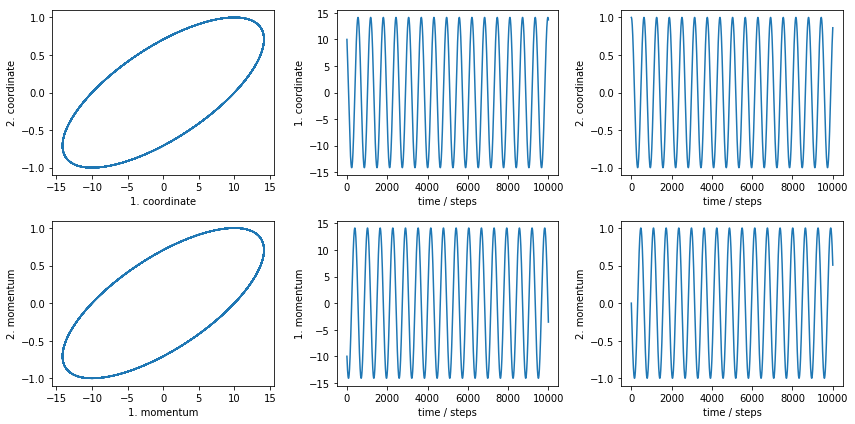

In [3]:
r, p = vv(nabla_potential, [10.0, 1.0], [-10.0, 0.0], 10000)

fig, axes = plt.subplots(2, 3, figsize=(12, 6))
axes[0, 0].plot(*r.T)
axes[1, 0].plot(*p.T)
axes[0, 0].set_xlabel('1. coordinate')
axes[0, 0].set_ylabel('2. coordinate')
axes[1, 0].set_xlabel('1. momentum')
axes[1, 0].set_ylabel('2. momentum')
for i in range(2):
    axes[0, 1 + i].plot(r[:, i])
    axes[1, 1 + i].plot(p[:, i])
    axes[0, 1 + i].set_ylabel(r'%d. coordinate' % (i + 1))
    axes[1, 1 + i].set_ylabel(r'%d. momentum' % (i + 1))
for ax in axes[:, 1:].flat:
    ax.set_xlabel(r'time / steps')
fig.tight_layout()

## Advanced topic: automatic differentiation

There is a powerfull package called ``pytorch``, which is mostly used for training neural networks. But it also has its uses for computational science outside the field of machine learning as we will see now:

1. ``pytorch`` has a low-level API for numerics which is very similar to ``nunmpy`` which alows us to translate our ``numpy``-based codes easily.
2. ``pytorch`` is, in contrast to ``numpy``, multithreaded and even supports calculations on GPUs.
3. ``pytorch`` includes the ``autograd`` submodule which allows us to compute gradients automatically.

Let's put this to the test by slightly modifying the potential and computing the gradient of this potential automatically...

In [4]:
import torch

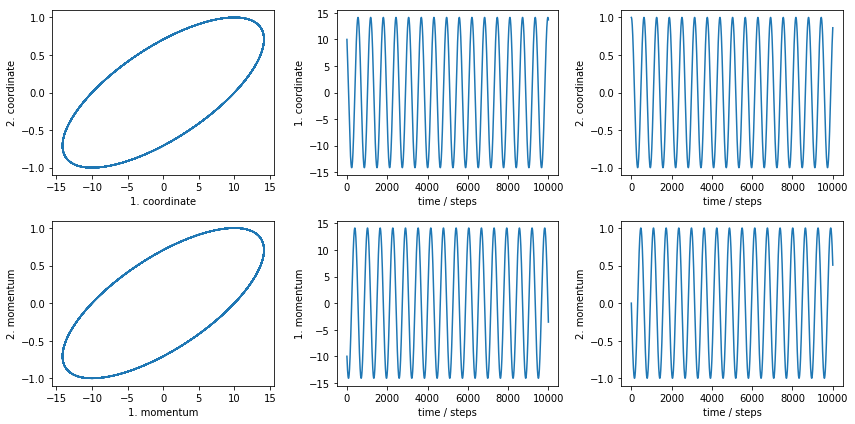

In [5]:
def potential(r):
    return 0.5 * torch.sum(r * r)

def gradient(r):
    r_ = torch.autograd.Variable(torch.from_numpy(r), requires_grad=True)
    phi = potential(r_)
    phi.backward()
    return r_.grad.data.numpy()

r, p = vv(gradient, [10.0, 1.0], [-10.0, 0.0], 10000)

fig, axes = plt.subplots(2, 3, figsize=(12, 6))
axes[0, 0].plot(*r.T)
axes[1, 0].plot(*p.T)
axes[0, 0].set_xlabel('1. coordinate')
axes[0, 0].set_ylabel('2. coordinate')
axes[1, 0].set_xlabel('1. momentum')
axes[1, 0].set_ylabel('2. momentum')
for i in range(2):
    axes[0, 1 + i].plot(r[:, i])
    axes[1, 1 + i].plot(p[:, i])
    axes[0, 1 + i].set_ylabel(r'%d. coordinate' % (i + 1))
    axes[1, 1 + i].set_ylabel(r'%d. momentum' % (i + 1))
for ax in axes[:, 1:].flat:
    ax.set_xlabel(r'time / steps')
fig.tight_layout()

Let's take it a step further and use a Lennard-Jones potential:

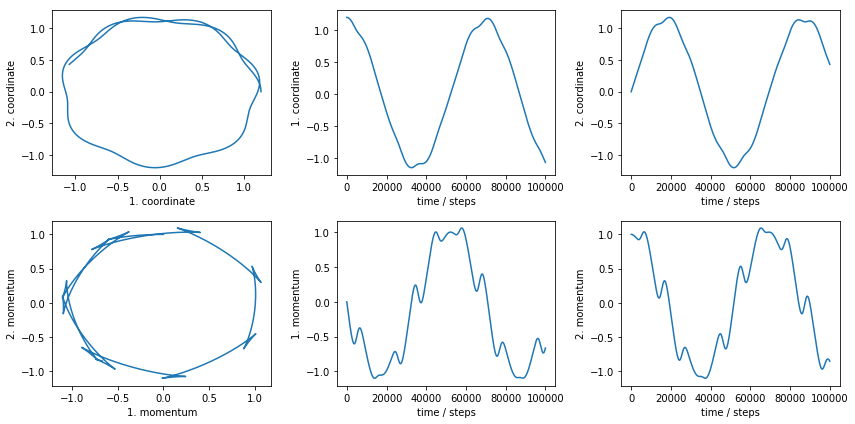

In [6]:
def potential(r):
    q = torch.pow(torch.norm(r), -6)
    return 4.0 * (q * (q - 1.0))

r, p = vv(gradient, [1.2, 0.0], [0.0, 1.0], 100000, dt=0.0001)

fig, axes = plt.subplots(2, 3, figsize=(12, 6))
axes[0, 0].plot(*r.T)
axes[1, 0].plot(*p.T)
axes[0, 0].set_xlabel('1. coordinate')
axes[0, 0].set_ylabel('2. coordinate')
axes[1, 0].set_xlabel('1. momentum')
axes[1, 0].set_ylabel('2. momentum')
for i in range(2):
    axes[0, 1 + i].plot(r[:, i])
    axes[1, 1 + i].plot(p[:, i])
    axes[0, 1 + i].set_ylabel(r'%d. coordinate' % (i + 1))
    axes[1, 1 + i].set_ylabel(r'%d. momentum' % (i + 1))
for ax in axes[:, 1:].flat:
    ax.set_xlabel(r'time / steps')
fig.tight_layout()

## Conclusion

We can make use of automatic differentiation to compute gradients instead of deriving/implementing the analytical expression. It does, though, slow down the calculation visibly.